# Training Convolutional Neural Nets for Anomaly Detection at L1Trigger

## Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.initializers import glorot_uniform
from sklearn.metrics import roc_curve, auc

import keras_tuner
from keras_tuner import Hyperband

import joblib

Using TensorFlow backend.


## Read input csv files into pandas

In [2]:
#ZeroBias data for training
df_zb = pd.read_csv('L1TRegionDump.csv')
df_zb

,event,eta,phi,et,position,electron,tau
0,0,6,3,0,0,1,1
1,0,7,3,1,0,1,1
2,0,5,3,0,0,1,1
3,0,8,3,0,0,1,1
4,0,4,3,0,0,1,1
...,...,...,...,...,...,...,...
79573531,315767,11,14,0,0,1,1
79573532,315767,1,14,0,0,1,1
79573533,315767,12,14,0,0,1,1
79573534,315767,0,14,0,0,1,1


In [3]:
#Original ZB data is sorted by event # only, where eta and phi are not sorted properly
#Re-sort here for easier 2D plotting and data pre-processing later
#e.g. in each event block (252 rows), rank phi first from 17 to 0, then for each phi value rank eta from 0 to 13
df_zb = df_zb.sort_values(by = ['event', 'phi', 'eta'], ascending = [True, False, True])
df_zb

,event,eta,phi,et,position,electron,tau
124,0,0,17,7,10,0,0
122,0,1,17,0,0,1,1
120,0,2,17,0,0,1,1
118,0,3,17,1,15,1,1
116,0,4,17,1,13,1,1
...,...,...,...,...,...,...,...
79573415,315767,9,0,0,0,1,1
79573417,315767,10,0,0,0,1,1
79573419,315767,11,0,0,0,1,1
79573421,315767,12,0,0,0,1,1


In [4]:
#Simulated VBFH->bb signal for test inference only (not to be used in training)
df_vbfh = pd.read_csv('cms-vbfh.csv')
df_vbfh

,eta,phi,et,position,electron,tau
0,0,0,14,1,0,1
1,0,1,14,0,0,1
2,0,2,14,0,0,1
3,0,3,14,0,0,1
4,0,4,14,1,1,1
...,...,...,...,...,...,...
251995,13,13,0,0,0,0
251996,13,14,1,11,1,1
251997,13,15,0,0,0,1
251998,13,16,0,15,1,1


In [5]:
#VBFH csv file has the column 'event' missing
#Make one here and then sort the same way as above
vbfh_event_col = []
for i in range(round(df_vbfh.shape[0]/252)):
    for j in range(252):
        vbfh_event_col.append(i)

df_vbfh['event'] = vbfh_event_col
df_vbfh = df_vbfh.sort_values(by = ['event', 'phi', 'eta'], ascending = [True, False, True])
df_vbfh

,eta,phi,et,position,electron,tau,event
17,0,17,0,0,0,0,0
35,1,17,0,0,0,0,0
53,2,17,0,0,0,0,0
71,3,17,0,0,0,0,0
89,4,17,4,15,1,1,0
...,...,...,...,...,...,...,...
251910,9,0,0,0,0,0,999
251928,10,0,0,0,0,0,999
251946,11,0,0,0,0,0,999
251964,12,0,0,0,0,0,999


In [ ]:
df_zb.shape
print(df_zb['eta'].min())
print(df_zb['eta'].max())
print(df_zb['phi'].min())
print(df_zb['phi'].max())
print(df_zb['et'].min())
print(df_zb['et'].max())
print(df_zb['position'].min())
print(df_zb['position'].max())

In [ ]:
df_vbfh.shape
print(df_vbfh['eta'].min())
print(df_vbfh['eta'].max())
print(df_vbfh['phi'].min())
print(df_vbfh['phi'].max())
print(df_vbfh['et'].min())
print(df_vbfh['et'].max())
print(df_vbfh['position'].min())
print(df_vbfh['position'].max())

## Plot 2D CaloRegion (18 phi * 14 eta) heatmap to visualize data

### Raw ZB data

In [ ]:
#Randomly select N events from raw ZB for plotting
N = 5
np.random.seed(0)
event_idx = np.random.randint(low = df_zb['event'].min(), high = df_zb['event'].max() + 1, size = N)
df_zb_example = []
df_zb_ET = []
df_zb_EleTauBits = []

for i in range(N):
    df_zb_example.append(df_zb.loc[df_zb['event'] == event_idx[i]])
    
    #Add EG/Tau bit labels for plotting purpose only
    EleTauBits = []
    for index, row in df_zb_example[i].iterrows():
        if row['electron'] == 1 and row['tau'] == 1:
            EleTauBits.append('1,1')
        if row['electron'] == 1 and row['tau'] == 0:
            EleTauBits.append('1,0')
        if row['electron'] == 0 and row['tau'] == 1:
            EleTauBits.append('0,1')
        if row['electron'] == 0 and row['tau'] == 0:
            EleTauBits.append('0,0')
    df_zb_example[i]['EleTauBits'] = EleTauBits
    
    #ET as heatmap intensity
    df_zb_ET.append(df_zb_example[i].pivot('phi','eta','et'))
    df_zb_ET[i] = df_zb_ET[i].sort_values('phi', ascending = False)#sorted this way so plots look exactly as conventional CaloRegion map
    
    #EG/Tau bits as alternative annotation
    df_zb_EleTauBits.append(df_zb_example[i].pivot('phi','eta','EleTauBits'))
    df_zb_EleTauBits[i] = df_zb_EleTauBits[i].sort_values('phi', ascending = False)
    

In [ ]:
#Draw heatmap with annotation being ET value
for i in range(N):
    fig, ax = plt.subplots(figsize = (7,7))
    ax = sns.heatmap(df_zb_ET[i], vmin = 0, vmax = 100, annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws={'label': 'ET (GeV)'})
    ax.set_title('Event #: ' + str(event_idx[i]))
    print('Event #: ' + str(event_idx[i]))
plt.show()

In [ ]:
#Draw heatmap with annotation being EG/Tau bits
for i in range(N):
    fig, ax = plt.subplots(figsize = (7,7))
    ax = sns.heatmap(df_zb_ET[i], vmin = 0, vmax = 100, annot = df_zb_EleTauBits[i], fmt = '', linewidths = 0.1, cmap = "Reds", cbar_kws={'label': 'ET (GeV)'})
    ax.set_title('Event #: ' + str(event_idx[i]))
    print('Event #: ' + str(event_idx[i]))
plt.show()

### Simulated VBFH sample

In [ ]:
#Randomly select N events from MC signal for plotting
N = 5
np.random.seed(0)
event_idx = np.random.randint(low = df_vbfh['event'].min(), high = df_vbfh['event'].max() + 1, size = N)
df_vbfh_example = []
df_vbfh_ET = []
df_vbfh_EleTauBits = []

for i in range(N):
    df_vbfh_example.append(df_vbfh.loc[df_vbfh['event'] == event_idx[i]])
    
    #Add EG/Tau bit labels for plotting purpose only
    EleTauBits = []
    for index, row in df_vbfh_example[i].iterrows():
        if row['electron'] == 1 and row['tau'] == 1:
            EleTauBits.append('1,1')
        if row['electron'] == 1 and row['tau'] == 0:
            EleTauBits.append('1,0')
        if row['electron'] == 0 and row['tau'] == 1:
            EleTauBits.append('0,1')
        if row['electron'] == 0 and row['tau'] == 0:
            EleTauBits.append('0,0')
    df_vbfh_example[i]['EleTauBits'] = EleTauBits
    
    #ET as heatmap intensity
    df_vbfh_ET.append(df_vbfh_example[i].pivot('phi','eta','et'))
    df_vbfh_ET[i] = df_vbfh_ET[i].sort_values('phi', ascending = False)#sorted this way so plots look exactly as conventional CaloRegion map
    
    #EG/Tau bits as alternative annotation
    df_vbfh_EleTauBits.append(df_vbfh_example[i].pivot('phi','eta','EleTauBits'))
    df_vbfh_EleTauBits[i] = df_vbfh_EleTauBits[i].sort_values('phi', ascending = False)

In [ ]:
#Draw heatmap with annotation being ET value
for i in range(N):
    fig, ax = plt.subplots(figsize = (7,7))
    ax = sns.heatmap(df_vbfh_ET[i], vmin = 0, vmax = 100, annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws={'label': 'ET (GeV)'})
    ax.set_title('Event #: ' + str(event_idx[i]))
    print('Event #: ' + str(event_idx[i]))
plt.show()

In [ ]:
#Draw heatmap with annotation being EG/Tau bits
for i in range(N):
    fig, ax = plt.subplots(figsize = (7,7))
    ax = sns.heatmap(df_vbfh_ET[i], vmin = 0, vmax = 100, annot = df_vbfh_EleTauBits[i], fmt = '', linewidths = 0.1, cmap = "Reds", cbar_kws={'label': 'ET (GeV)'})
    ax.set_title('Event #: ' + str(event_idx[i]))
    print('Event #: ' + str(event_idx[i]))
plt.show()

In [6]:
#Keep only (eta, phi, ET) as inputs for the moment
df_zb_reduced = df_zb.drop(columns = ['event', 'position', 'electron', 'tau'])
df_vbfh_reduced = df_vbfh.drop(columns = ['event', 'position', 'electron', 'tau'])

#Convert pandas dataframes to numpy arrays for easier manipulation
#Array shape: # of events, # of Calo regions, (eta, phi, ET)
df_zb_reduced = df_zb_reduced.to_numpy().reshape(round(df_zb.shape[0]/252), 252, 3)
df_vbfh_reduced = df_vbfh_reduced.to_numpy().reshape(round(df_vbfh.shape[0]/252), 252, 3)

df_zb_reduced = df_zb_reduced.astype(dtype = 'float64')
df_vbfh_reduced = df_vbfh_reduced.astype(dtype = 'float64')

## DIY signal events from raw ZB data for training

In [11]:
#Split raw ZB data into two halves
#First half for DIY signal to be used in training
#Second half kept unchanged for background to be used in training
df_zb_sig, df_zb_bkg = train_test_split(df_zb_reduced, test_size = 0.5, random_state = 123)

In [12]:
#DIY 'signal' events from ZB by randomly assigning high ET to one of the 252 Calo regions
np.random.seed(0)
region = np.random.randint(low = 0, high = 252, size = df_zb_sig.shape[0])
ETvalue = np.random.randint(low = 20, high = 100, size = df_zb_sig.shape[0])
for i in range(df_zb_sig.shape[0]):
    df_zb_sig[i][region[i]][2] = ETvalue[i]

In [ ]:
#Visualize and compare the CaloRegion heatmaps between 'signal' (DIY from ZB) and 'background' (raw ZB)
N = 5
np.random.seed(0)
sig_event_idx = np.random.randint(low = 0, high = df_zb_sig.shape[0], size = N)
bkg_event_idx = np.random.randint(low = 0, high = df_zb_bkg.shape[0], size = N)
sig = []
bkg = []
print('Signal examples:\n')
for i in range(N):
    sig.append(pd.DataFrame(df_zb_sig[sig_event_idx[i]], columns = ['eta', 'phi', 'et']))
    sig[i] = sig[i].pivot('phi', 'eta', 'et')
    sig[i] = sig[i].sort_values('phi', ascending = False)
    fig, ax = plt.subplots(figsize = (7,7))
    ax = sns.heatmap(sig[i], vmin = 0, vmax = 100, annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws={'label': 'ET (GeV)'})
    ax.set_title('Event # in df_zb_sig: ' + str(sig_event_idx[i]))
plt.show()
print('Background examples:\n')
for i in range(N):
    bkg.append(pd.DataFrame(df_zb_bkg[bkg_event_idx[i]], columns = ['eta','phi','et']))
    bkg[i] = bkg[i].pivot('phi','eta','et')
    bkg[i] = bkg[i].sort_values('phi', ascending = False)
    fig, ax = plt.subplots(figsize = (7,7))
    ax = sns.heatmap(bkg[i], vmin = 0, vmax = 100, annot = True, linewidths = 0.1, cmap = "Reds", cbar_kws={'label': 'ET (GeV)'})
    ax.set_title('Event # in df_zb_bkg: ' + str(bkg_event_idx[i]))
plt.show()

## Pre-process training data

In [13]:
#Tag signal with label 1 and background with label 0
sig_tag = np.ones((df_zb_sig.shape[0], 1))
bkg_tag = np.zeros((df_zb_bkg.shape[0], 1))

#Combine signal and background into one training set
X = np.concatenate((df_zb_sig, df_zb_bkg))
Y = np.concatenate((sig_tag, bkg_tag))

In [14]:
#Partition the whole training set into train/val/test sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state = 123)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

In [16]:
#Standardize the input features to speed up convergence
#Here only ET for the moment
#Mean and std computed and fixed from the train and val sets combined
#These values need to be saved and later appled to all other events at testing/deployment
ET_mean = X_train_val[:,:,2].mean()
ET_std = X_train_val[:,:,2].std()
print("ET mean in train+val sets: " + str(ET_mean))
print("ET standard deviation in train+val sets: " + str(ET_std))

X_train[:,:,2] = (X_train[:,:,2] - ET_mean)/ET_std
X_val[:,:,2] = (X_val[:,:,2] - ET_mean)/ET_std
X_test[:,:,2] = (X_test[:,:,2] - ET_mean)/ET_std

ET mean in train+val sets: 1.342997821131456
ET standard deviation in train+val sets: 4.000118761331342


In [19]:
#Standardize the VBFH test sample in the same way
df_vbfh_reduced[:,:,2] = (df_vbfh_reduced[:,:,2] - ET_mean)/ET_std

In [20]:
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (189460, 252, 3)
Y_train.shape: (189460, 1)
X_val.shape: (63154, 252, 3)
Y_val.shape: (63154, 1)
X_test.shape: (63154, 252, 3)
Y_test.shape: (63154, 1)

Total number of sig/bkg examples: 157884/157884 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 94859/94601 (50.1%/49.9%)
val   : 31545/31609 (49.9%/50.1%)
test  : 31480/31674 (49.8%/50.2%)


In [22]:
#The above inputs are numpy arrays with shape (# of events, 252 CaloRegions, 3 values (phi, eta, ET))
#Need to re-shape the inputs to make sense with ConvNet
#2DConvNet takes each input like a pixel image with height + width + colours, properly arranged into 3D arrays
#Therefore our set of inputs should instead have shape (# of events, 18 phi regions, 14 eta regions, 1 ET value)
#For the moment just keep 1 ET value, we could later add EG/Tau bits to the last dim

#E.g.
#X_train is numpy array with shape (# of events, 252 CaloRegions, 3 values (phi, eta, ET)), as shown in previous output
#Where for each event block the '252 CaloRegions' is sorted by (...['phi', 'eta'], ascending = [False, True]...)
#Meaning when the 2nd dim is running from 0 to 251, the (phi, eta) is running from (17, 0), (17, 1), (17, 2),..., (17, 13), (16, 0), (16, 1),..., (0, 0), (0, 1),..., (0, 13)

#In the re-shaped inputs, we want the same sorting in (phi, eta) like above
#Since this means the ConvNet would be scanning each input event like a pixel image on the 18-by-14 CaloRegion map
#From left to right then top to bottom
#We just need to roll each event block from 252 to 18-by-14, with the same ordering

#Note here X_train_reshaped[event#][idx_0to17 means phi_17to0][idx_0to13 means eta_0to13][single ET value]
#Note in X_train the 2nd dim [j*14+k] running from 0 to 251, with phi sorted first in descending and eta sorted second in ascending

X_train_reshaped = np.zeros((X_train.shape[0], 18, 14, 1))
for i in range(X_train_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            X_train_reshaped[i][j][k][0] = X_train[i][j*14+k][2]

X_val_reshaped = np.zeros((X_val.shape[0], 18, 14, 1))
for i in range(X_val_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            X_val_reshaped[i][j][k][0] = X_val[i][j*14+k][2]

X_test_reshaped = np.zeros((X_test.shape[0], 18, 14, 1))
for i in range(X_test_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            X_test_reshaped[i][j][k][0] = X_test[i][j*14+k][2]

df_vbfh_reshaped = np.zeros((df_vbfh_reduced.shape[0], 18, 14, 1))
for i in range(df_vbfh_reshaped.shape[0]):
    for j in range(18):
        for k in range(14):
            df_vbfh_reshaped[i][j][k][0] = df_vbfh_reduced[i][j*14+k][2]

In [23]:
print("X_train_reshaped.shape: " + str(X_train_reshaped.shape))
print("X_val_reshaped.shape: " + str(X_val_reshaped.shape))
print("X_test_reshaped.shape: " + str(X_test_reshaped.shape))
print("df_vbfh_reshaped.shape: " + str(df_vbfh_reshaped.shape))

X_train_reshaped.shape: (189460, 18, 14, 1)
X_val_reshaped.shape: (63154, 18, 14, 1)
X_test_reshaped.shape: (63154, 18, 14, 1)
df_vbfh_reshaped.shape: (1000, 18, 14, 1)


## Optimal hyperparameters searching

In [ ]:
#placeholder

## Model training

In [24]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation = 'relu', input_shape = (18, 14, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(20, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 12, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 6, 10)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 4, 20)          1820      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 2, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1210      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [25]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
history = model.fit(X_train_reshaped, Y_train,
                    epochs = 4,
                    validation_data = (X_val_reshaped, Y_val),
                    batch_size = 16)

Train on 189460 samples, validate on 63154 samples
Epoch 1/4
189460/189460 [==============================] - 47s 247us/sample - loss: 0.1853 - accuracy: 0.9283 - val_loss: 0.1583 - val_accuracy: 0.9398
Epoch 2/4
189460/189460 [==============================] - 45s 239us/sample - loss: 0.1605 - accuracy: 0.9381 - val_loss: 0.1543 - val_accuracy: 0.9407
Epoch 3/4
189460/189460 [==============================] - 45s 239us/sample - loss: 0.1557 - accuracy: 0.9390 - val_loss: 0.1519 - val_accuracy: 0.9410
Epoch 4/4
189460/189460 [==============================] - 45s 239us/sample - loss: 0.1532 - accuracy: 0.9405 - val_loss: 0.1564 - val_accuracy: 0.9369


Text(0, 0.5, 'Accuracy (y_pred = y_true)')

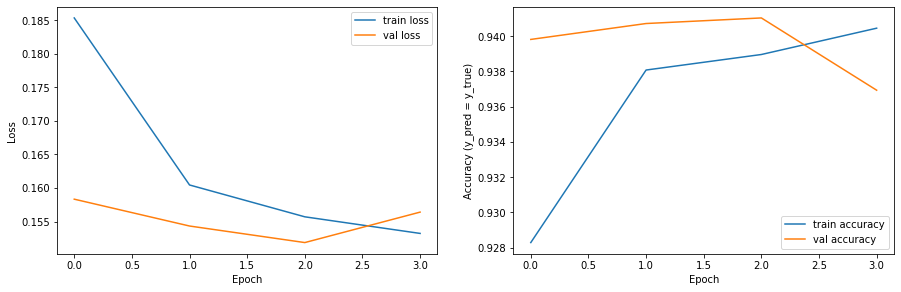

In [27]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Evaluate the trained model with test set

In [28]:
#Here the test set is composed of DIY signal from ZB and background from raw ZB
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number, 18, 14, 1))
X_test_bkg = np.zeros((test_bkg_number, 18, 14, 1))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:,:,:] = X_test_reshaped[i,:,:,:]
        j = j + 1
    else:
        X_test_bkg[k,:,:,:] = X_test_reshaped[i,:,:,:]
        k = k + 1

#Train+val set
train_sig_number = np.count_nonzero(Y_train)
train_bkg_number = np.count_nonzero(Y_train == 0)

X_train_sig = np.zeros((train_sig_number, 18, 14, 1))
X_train_bkg = np.zeros((train_bkg_number, 18, 14, 1))

j = 0
k = 0
for i in range(Y_train.shape[0]):
    if Y_train[i,0] == 1:
        X_train_sig[j,:] = X_train_reshaped[i,:,:,:]
        j = j + 1
    else:
        X_train_bkg[k,:] = X_train_reshaped[i,:,:,:]
        k = k + 1

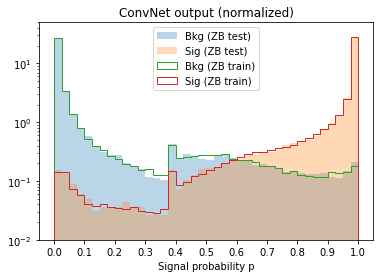

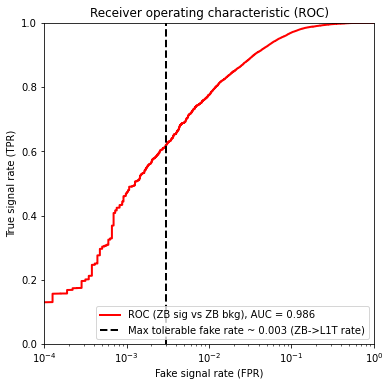

In [29]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)')
plt.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (ZB test)', log = True)
plt.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Sig (ZB test)')
plt.hist(model.predict(X_train_bkg), density = 1, range = (0.0, 1.0), bins = 40, label = 'Bkg (ZB train)', histtype = 'step')
plt.hist(model.predict(X_train_sig), density = 1, range = (0.0, 1.0), bins = 40, label = 'Sig (ZB train)', histtype = 'step')
plt.legend(loc = 'upper center')
plt.title('ConvNet output (normalized)')
plt.xlabel('Signal probability p')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.ylim(1e-2,5e1)
plt.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test_reshaped)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC (ZB sig vs ZB bkg), AUC = %.3f' % (roc_auc))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB->L1T rate)')
axes.set_xlim([0.0001, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xscale(value = "log")
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

#results = model.evaluate(X_test_reshaped, Y_test, verbose = 0, batch_size = 1024)
#print("Test loss, test accuracy:", results)

In [30]:
#Now evaluate with the VBFH sample which was not used in training at all
#Mix the VBFH with ZB background to form new test set
Y_vbfh = np.ones((1000,1))
Y_test_bkg = np.zeros((X_test_bkg.shape[0], 1))
Y_mixed = np.concatenate((Y_vbfh,Y_test_bkg))
X_mixed = np.concatenate((df_vbfh_reshaped, X_test_bkg))

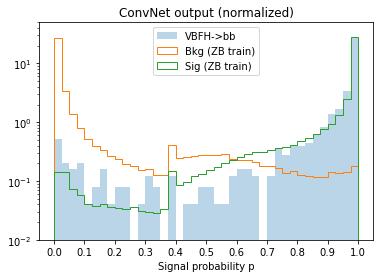

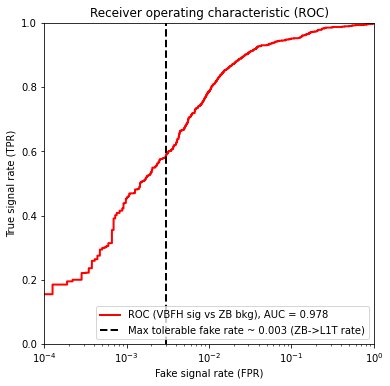

Test loss, test accuracy on VBFH: [0.1822497844696045, 0.948]


In [31]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)')
plt.hist(model.predict(df_vbfh_reshaped), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'VBFH->bb', log = True)
plt.hist(model.predict(X_train_bkg), density = 1, range = (0.0, 1.0), bins = 40, label = 'Bkg (ZB train)', histtype = 'step')
plt.hist(model.predict(X_train_sig), density = 1, range = (0.0, 1.0), bins = 40, label = 'Sig (ZB train)', histtype = 'step')
plt.legend(loc = 'upper center')
plt.title('ConvNet output (normalized)')
plt.xlabel('Signal probability p')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.ylim(1e-2,5e1)
plt.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_mixed_predict = model.predict(X_mixed)
fpr, tpr, thresholds = roc_curve(Y_mixed, Y_mixed_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC (VBFH sig vs ZB bkg), AUC = %.3f' % (roc_auc))
#axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.plot([0.003, 0.003], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Max tolerable fake rate ~ 0.003 (ZB->L1T rate)')
axes.set_xlim([0.0001, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xscale(value = "log")
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results_vbfh = model.evaluate(df_vbfh_reshaped, Y_vbfh, verbose = 0, batch_size = 1024)
print("Test loss, test accuracy on VBFH:", results_vbfh)

## Save trained model

In [ ]:
#Baby model as a benchmark
!rm -r benchmark/*
joblib.dump(value = np.array([ET_mean, ET_std]), filename = 'benchmark/CNN_ET_scaler.gz')#for standardizing input features
model.save('benchmark/CNN_trained')

## Load saved model for production

In [ ]:
savedscaler = joblib.load('benchmark/CNN_ET_scaler.gz')
savedmodel = keras.models.load_model('benchmark/CNN_trained')
savedmodel.summary()